# Experiment: NeighborNorm Directional Leakage Score

Objective:
- Compute source-anchored leakage scores using `tl.leakage_score`.
- Prioritize genes with strong source specificity plus low-level OFF-source spread near source cells.

Success criteria:
- The workflow runs end-to-end on your dataset.
- `adata.varm["leakage"]` and `adata.uns["leakage"]` are populated.
- Genes with high `presence_ratio` (for example 0.4 to 0.6) are de-prioritized by low `pr_score` and low `near_enrichment`.


In [31]:
# Setup: imports, paths, and module reload
from __future__ import annotations

from pathlib import Path
import importlib
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from anndata import read_h5ad

# Make sure repo modules are importable when running from notebooks/.
REPO_ROOT = Path.cwd()
if REPO_ROOT.name == "notebooks":
    REPO_ROOT = REPO_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import tl
import leakage_score as leakage_score_module

importlib.reload(leakage_score_module)
importlib.reload(tl)

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

print(f"repo_root={REPO_ROOT}")


repo_root=/Users/christoffer/work/karolinska/development/NeighborNorm


## Plan

1. Configure dataset path and directional leakage parameters.
2. Load AnnData and run `tl.leakage_score`.
3. Inspect top genes and marker sanity checks.
4. Check housekeeping-like prefixes and mid-range `presence_ratio` genes in top-ranked genes.
5. Visualize `spray_delta` vs `off_type_frac`.


In [34]:
# Configuration
DATA_PATH = Path("/Volumes/processing2/RRmap/data/RRmap_metadata_fixed_update.h5ad")  # <- set this
LAYER = "counts"  # set to None to use adata.X

CELL_TYPE_KEY = "anno_L2"
CONNECTIVITIES_KEY = "connectivities"
KEY_ADDED = "leakage"

SPECIFICITY_THRESH = 0.75
SOURCE_MASS_COVER = 0.95
MAX_SOURCES = 1
LOW_COUNT_MAX = 2
ALPHA = 2.0
PR0 = 0.02
SIGMA = 0.8
EPS = 1e-8

MARKERS = ["GFAP", "MBP", "PLP1", "AQP4"]
TOP_N = 30

SAVE_OUTPUTS = False
OUT_H5AD = Path("./leakage_scored.h5ad")
OUT_CSV = Path("./leakage_scores.csv")

if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Set DATA_PATH to an existing .h5ad file. Current value: {DATA_PATH}"
    )


In [35]:
# Load data and quick input check
adata = read_h5ad(DATA_PATH)

print(f"adata shape: {adata.n_obs:,} cells x {adata.n_vars:,} genes")
print(f"layer requested: {LAYER}")
print(f"cell_type_key in obs: {CELL_TYPE_KEY in adata.obs}")
print(f"connectivities_key in obsp: {CONNECTIVITIES_KEY in adata.obsp}")
print(f"available layers: {list(adata.layers.keys())[:10]}")

if LAYER is not None and LAYER not in adata.layers:
    raise KeyError(f"Layer '{LAYER}' not found in adata.layers.")
if CELL_TYPE_KEY not in adata.obs:
    raise KeyError(f"'{CELL_TYPE_KEY}' not found in adata.obs.")
if CONNECTIVITIES_KEY not in adata.obsp:
    raise KeyError(f"'{CONNECTIVITIES_KEY}' not found in adata.obsp.")


adata shape: 877,141 cells x 5,101 genes
layer requested: counts
cell_type_key in obs: True
connectivities_key in obsp: True
available layers: ['counts', 'normalized']


In [36]:
# Run directional leakage scoring
leakage_df = tl.leakage_score(
    adata,
    layer=LAYER,
    cell_type_key=CELL_TYPE_KEY,
    key_added=KEY_ADDED,
    specificity_thresh=SPECIFICITY_THRESH,
    source_mass_cover=SOURCE_MASS_COVER,
    max_sources=MAX_SOURCES,
    low_count_max=LOW_COUNT_MAX,
    alpha=ALPHA,
    pr0=PR0,
    sigma=SIGMA,
    connectivities_key=CONNECTIVITIES_KEY,
    copy=False,
    eps=EPS,
)

print(f"computed rows: {len(leakage_df):,}")
print(f"stored in varm: {KEY_ADDED in adata.varm}")
print(f"stored in uns: {KEY_ADDED in adata.uns}")
print("n_eligible_genes:", adata.uns[KEY_ADDED].get("n_eligible_genes"))


computed rows: 5,101
stored in varm: True
stored in uns: True
n_eligible_genes: 22


In [37]:
# Top-ranked genes by leakage score
cols = [
    "gene",
    "leakage_score",
    "top1_ct",
    "top1_frac",
    "sources",
    "off_type_frac",
    "near_enrichment",
    "spray_delta",
    "presence_ratio",
    "pr_score",
    "rank",
    "eligible",
]
cols = [c for c in cols if c in leakage_df.columns]

top_df = leakage_df.loc[:, cols].head(TOP_N)
top_df


,gene,leakage_score,top1_ct,top1_frac,sources,off_type_frac,near_enrichment,spray_delta,presence_ratio,pr_score,rank,eligible
0,Cd19,6.234649,B cell,0.778458,B cell,0.221542,32.413181,-0.020510,0.005866,0.308708,1.0,True
1,Cd79a,5.706081,B cell,0.786143,B cell,0.213857,34.294529,-0.166180,0.011475,0.785747,2.0,True
2,Ms4a1,5.694188,B cell,0.774735,B cell,0.225265,30.753158,-0.090922,0.009087,0.614966,3.0,True
3,Fcmr,5.569708,B cell,0.761800,B cell,0.238200,29.032857,-0.093814,0.009218,0.625805,4.0,True
4,Cldn19,4.788371,Schwann cell,0.769535,Schwann cell,0.230465,21.430925,-0.011634,0.010377,0.714374,5.0,True
5,Dnah11,2.605278,Other,0.763261,Other,0.236739,16.109373,-0.031588,0.003807,0.116514,6.0,True
6,Pln,2.313307,VSMC,0.779018,VSMC,0.220982,16.342514,-0.055974,0.006167,0.339096,7.0,True
7,Stoml3,2.004935,Other,0.836437,Other,0.163563,23.700996,-0.025361,0.002821,0.049926,8.0,True
8,Isl2,1.828220,Neuron,0.773269,Neuron,0.226731,6.125418,-0.007875,0.023864,0.975917,9.0,True
9,Gpr26,1.110460,Interneuron,0.755646,Interneuron,0.244354,5.255009,-0.008853,0.066079,0.327630,10.0,True


In [38]:
# Sanity checks: markers + housekeeping + mid presence_ratio genes
summary = tl.leakage_sanity_check(leakage_df, markers=MARKERS, top_n=TOP_N)

print(f"Top {TOP_N} genes by leakage_score:")
display(summary["top_genes"][cols].head(TOP_N))

print("Marker summary:")
display(summary["marker_summary"])

print("Housekeeping-like genes in top set (MT-/RPL/RPS/EEF1):")
display(summary["housekeeping_top"])

print("Genes with presence_ratio in [0.4, 0.6] in top set (should be few):")
display(summary["mid_presence_top"])


Top 30 genes by leakage_score:


,gene,leakage_score,top1_ct,top1_frac,sources,off_type_frac,near_enrichment,spray_delta,presence_ratio,pr_score,rank,eligible
0,Cd19,6.234649,B cell,0.778458,B cell,0.221542,32.413181,-0.020510,0.005866,0.308708,1.0,True
1,Cd79a,5.706081,B cell,0.786143,B cell,0.213857,34.294529,-0.166180,0.011475,0.785747,2.0,True
2,Ms4a1,5.694188,B cell,0.774735,B cell,0.225265,30.753158,-0.090922,0.009087,0.614966,3.0,True
3,Fcmr,5.569708,B cell,0.761800,B cell,0.238200,29.032857,-0.093814,0.009218,0.625805,4.0,True
4,Cldn19,4.788371,Schwann cell,0.769535,Schwann cell,0.230465,21.430925,-0.011634,0.010377,0.714374,5.0,True
5,Dnah11,2.605278,Other,0.763261,Other,0.236739,16.109373,-0.031588,0.003807,0.116514,6.0,True
6,Pln,2.313307,VSMC,0.779018,VSMC,0.220982,16.342514,-0.055974,0.006167,0.339096,7.0,True
7,Stoml3,2.004935,Other,0.836437,Other,0.163563,23.700996,-0.025361,0.002821,0.049926,8.0,True
8,Isl2,1.828220,Neuron,0.773269,Neuron,0.226731,6.125418,-0.007875,0.023864,0.975917,9.0,True
9,Gpr26,1.110460,Interneuron,0.755646,Interneuron,0.244354,5.255009,-0.008853,0.066079,0.327630,10.0,True


Marker summary:


,gene,in_top_n,rank,eligible,top1_frac,sources,presence_ratio,near_enrichment
0,GFAP,False,NaN,NaN,NaN,,NaN,NaN
1,MBP,False,NaN,NaN,NaN,,NaN,NaN
2,PLP1,False,NaN,NaN,NaN,,NaN,NaN
3,AQP4,False,NaN,NaN,NaN,,NaN,NaN


Housekeeping-like genes in top set (MT-/RPL/RPS/EEF1):


,gene,leakage_score,top1_frac,eligible,rank


Genes with presence_ratio in [0.4, 0.6] in top set (should be few):


,gene,leakage_score,presence_ratio,pr_score,near_enrichment,spray_delta,rank


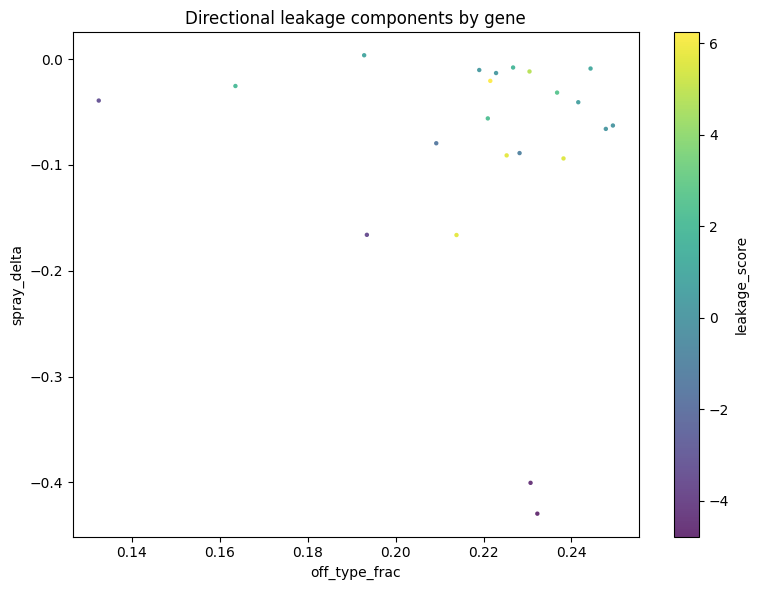

In [39]:
# Quick plot helper: spray_delta vs off_type_frac, colored by leakage_score
plot_df = tl.prepare_leakage_scatter(leakage_df)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    plot_df["off_type_frac"],
    plot_df["spray_delta"],
    c=plot_df["leakage_score"],
    s=10,
    cmap="viridis",
    alpha=0.8,
    linewidths=0,
)
ax.set_xlabel("off_type_frac")
ax.set_ylabel("spray_delta")
ax.set_title("Directional leakage components by gene")
cb = plt.colorbar(sc, ax=ax)
cb.set_label("leakage_score")

marker_df = plot_df[plot_df["gene"].isin(MARKERS)]
for _, row in marker_df.iterrows():
    ax.text(row["off_type_frac"], row["spray_delta"], row["gene"], fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# Optional save
if SAVE_OUTPUTS:
    adata.write_h5ad(OUT_H5AD)
    leakage_df.to_csv(OUT_CSV, index=False)
    print(f"wrote {OUT_H5AD}")
    print(f"wrote {OUT_CSV}")
else:
    print("SAVE_OUTPUTS=False, skipping write.")


## Interpretation Notes

- `top1_frac` defines source specificity. Genes below `specificity_thresh` are ineligible.
- `pr_score` is a band-pass score of `presence_ratio` centered at `pr0`.
- `near_enrichment` compares OFF+ near-source prevalence to OFF baseline near-source prevalence.
- `spray_delta = spray_near - spray_far` captures stronger low-count halo near source boundaries.
- `leakage_score` combines robust-z components and specificity weighting.

Suggested next checks:
- Inspect recipient OFF cell types for top genes.
- Sweep `pr0`, `sigma`, and `specificity_thresh` for robustness.
- Compare per-sample behavior if sample IDs are available.
